# DECCS for Synthetic Data Set

This is an illustration for how DECCS can be applied to the synthetic data set **SYNTH** shown in our paper [Deep Clustering With Consensus Representations](https://arxiv.org/abs/2210.07063). 
Be aware that the numbers and images can be different to the ones in the paper due to randomness. 

In [1]:
# Importing all necessary libraries

# ipython magic functions for automatic reloading coda changes in .py files
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import OrderedDict
# external packages
import torch
import torchvision
import numpy as np
import sklearn
import matplotlib 
%matplotlib inline

print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

# use full screen width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Versions
torch:  1.11.0
torchvision:  0.12.0
numpy:  1.22.3
scikit-learn: 1.1.1
matplotlib: 3.5.1


In [2]:
# import helper functions
from utils.utils import *
from utils.visualize import *

In [3]:
# Setup base path to save files created during the execution of the notebook
base_path = os.path.join("results", "notebooks","synth")
setup_directory(base_path)

In [4]:
# Setup base ensemble
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

def get_clusterer_dict(n_clusters=2):
    clusterer_dict = OrderedDict({"KM": KMeans(n_clusters=n_clusters),
                                  "SC": SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',n_neighbors=10, assign_labels="discretize"),
                                  "AGG": AgglomerativeClustering(n_clusters=n_clusters, linkage="single"),
                                  "GMM": GaussianMixture(n_components=n_clusters, covariance_type="full", n_init=10, reg_covar=1e-5),
                                 })
    return clusterer_dict

### Load running example

In [5]:
from utils.data import generate_synthetic_example, load_synthetic
data, labels = load_synthetic("two-moons-plus-two-blobs", as_tensor=True)

Dataset:  two-moons-plus-two-blobs

Data Set Information
Number of data points:  2000
Number of dimensions:  2
Mean: 0.91, Standard deviation: 0.84
Min: -1.07, Max: 2.13
Number of classes:  4
Class distribution:
 [(0, 500), (1, 500), (2, 500), (3, 500)]



In [6]:
from utils.data import print_data_statistics

data_train, labels_train = data, labels
# generate independent data set for evaluation of AE
data_eval, labels_eval = generate_synthetic_example()

print("Train Data")
print_data_statistics(data_train, labels_train)

print("Eval Data")
print_data_statistics(data_eval, labels_eval)


Train Data

Data Set Information
Number of data points:  2000
Number of dimensions:  2
Mean: 0.91, Standard deviation: 0.84
Min: -1.07, Max: 2.13
Number of classes:  4
Class distribution:
 [(0, 500), (1, 500), (2, 500), (3, 500)]

Eval Data

Data Set Information
Number of data points:  3000
Number of dimensions:  2
Mean: 0.73, Standard deviation: 0.84
Min: -1.08, Max: 2.11
Number of classes:  4
Class distribution:
 [(0, 1000), (1, 1000), (2, 500), (3, 500)]



### Plot initial clusterings

/export/home/miklautzl92dm/.local/lib/python3.10/site-packages/scikit_learn-1.1.1-py3.10-linux-x86_64.egg/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


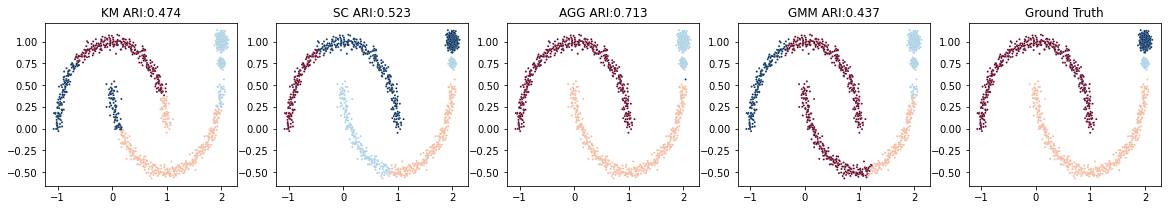

In [7]:
from utils.ensemble import create_cluster_dict

n_clusters = len(set(labels.tolist()))
clusterer_dict = get_clusterer_dict(n_clusters=n_clusters)
cluster_dict = create_cluster_dict(clusterer_dict, data_train, labels_train)
plot_clusterings(data_train, cluster_dict, labels_train.numpy())

------------
## Train autoencoder

In [8]:
from model.autoencoder import Autoencoder
input_dim = 2
embedding_size = 2
model = Autoencoder(layers=[input_dim, 20, 20, embedding_size])
print(model)

Autoencoder(
  (encoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (decoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)


In [9]:
# Set all parameters needed for training
batch_size = 100
learning_rate = 1e-3
training_iterations = 10000
device = torch.device("cpu")
print("Use device: ", device)
# load model to device
model.to(device)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data_train, labels_train)),
                                          batch_size=batch_size,
                                          # sample random mini-batches from the data
                                          shuffle=True,
                                          drop_last=True)


trainloader_eval = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data_train, labels_train)),
                                          batch_size=batch_size,
                                          # sample random mini-batches from the data
                                          shuffle=False,
                                          drop_last=False)

evalloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data_eval, labels_eval)),
                                         batch_size=batch_size,
                                         # Note that we deactivate the shuffling 
                                         shuffle=False,
                                         drop_last=False)

loss_fn = torch.nn.MSELoss()
model_name = "ae-model-idx-0.pth"
pretrained_model_path = os.path.join("results", "two-moons-plus-two-blobs", "pretrained_aes", model_name)

Use device:  cpu


In [10]:
TRAIN = False

if TRAIN:
    model.fit(loss_fn=loss_fn,
              lr=learning_rate,
              optimizer_fn=lambda params, lr: torch.optim.Adam(params, lr, weight_decay=1e-3),
              training_iterations=training_iterations, 
              dataloader=trainloader,
              evalloader=evalloader,
              model_path=pretrained_model_path, 
              batch_size=batch_size,
              patience=10,
              device=device)
else:
    # load model
    state_dict = torch.load(pretrained_model_path, map_location=device)
    model.load_state_dict(state_dict["model"])

### Check performance on embedding

/export/home/miklautzl92dm/.local/lib/python3.10/site-packages/scikit_learn-1.1.1-py3.10-linux-x86_64.egg/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/export/home/miklautzl92dm/.local/lib/python3.10/site-packages/scikit_learn-1.1.1-py3.10-linux-x86_64.egg/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/export/home/miklautzl92dm/.local/lib/python3.10/site-packages/scikit_learn-1.1.1-py3.10-linux-x86_64.egg/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


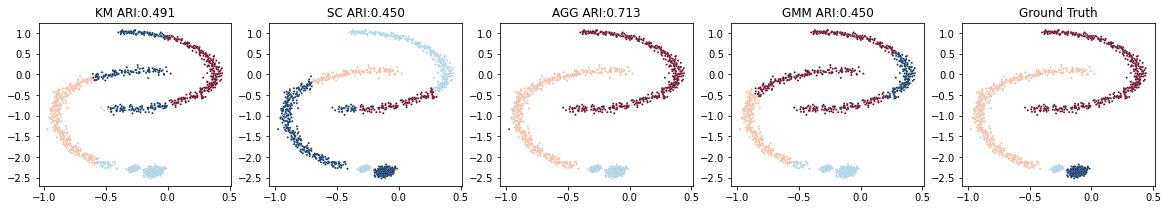

In [11]:
embedded_data = encode_batchwise(trainloader_eval, model, device)

clusterer_dict = get_clusterer_dict(n_clusters=n_clusters)
cluster_dict = create_cluster_dict(clusterer_dict, embedded_data, labels_train)
plot_clusterings(embedded_data, cluster_dict, labels_train.numpy())

# Apply DECCS

In [12]:
from model.ensemble import ClassifierEnsemble
from utils.train import alternate_optimization

In [13]:
model_path = os.path.join(base_path, "deccs.pth")
# path to save plots. needs to be specified below in case you want to have them plotted and saved locally.
plot_path = os.path.join(base_path, "plots")
setup_directory(plot_path)
model_path, plot_path

('results/notebooks/synth/deccs.pth', 'results/notebooks/synth/plots')

In [14]:
# stability_threshold called tau in the paper indicates when a stable agreement is reached
# stability_threshold=1e-3
# Set to -np.inf so that we will train until max_round is reached
stability_threshold=-np.inf

optimizer_fn = lambda params, lr: torch.optim.SGD(params, lr, momentum=0.9)
subsample_size_ratio=0.5

TRAIN = False

if TRAIN:
    model, classifier_ensemble = alternate_optimization(# Pretrained input model, e.g. Autoencoder
                                                        model=model,
                                                        # Full input data
                                                        data=data,
                                                        # Ground truth labels for calculation of cluster performance metrics during training
                                                        gt_labels=labels.numpy(),
                                                        # Function which returns the parameterized ensemble
                                                        clusterer_dict_fn=get_clusterer_dict,
                                                        # Ensemble of classifiers that should be used to approximate the clusterings
                                                        ensemble_class=ClassifierEnsemble,
                                                        # Maximum number of rounds that the algorithm should run.
                                                        max_rounds=10,
                                                        # max iterations for representation and classifier updates. 
                                                        # Might stop sooner based on early stopping and patience parameter
                                                        max_iterations=20000,
                                                        clf_iterations=20000,
                                                        # number of minibatch iterations that should be used for early stopping
                                                        patience=500,
                                                        # learning rates for classifiers in the ensemble and model
                                                        clf_lr=1e-2,
                                                        repr_lr=1e-3,
                                                        # corresponding optimizers
                                                        clf_optimizer_fn=optimizer_fn,
                                                        repr_optimizer_fn=optimizer_fn,
                                                        # size of data sample to use for clustering in each round
                                                        subsample_size=int(subsample_size_ratio*data.shape[0]),
                                                        # specifies how many data points should be used to calculate eval loss for early stopping.
                                                        # Calculated as train_split_ratio*subsample_size
                                                        train_split_ratio=0.5,
                                                        stability_threshold=stability_threshold,
                                                        # Indicates if AE reconstruction loss should be used during train for regularization
                                                        use_rec=False,
                                                        # weight of reconstruction loss if used
                                                        regularizer_weight = 0.0,
                                                        # activates consensus objective
                                                        use_mean=True,
                                                        #  set to a value > 0, it will rampup a weighting parameter over the course of training until
                                                        # half of max_rounds and then the mean_weight_rampup value is reached.
                                                        mean_weight_rampup=10,
                                                        # makes use of the unclustered data during DECCS
                                                        use_unlabelled=True,
                                                        # The hardening_agreement_threshold indicates when the agreement procedure should harden, i.e., get closer to full agreement.
                                                        # By setting it to 1, you would not use it. But for ensembles with high diversity or independent clusterings, this can be used to speed up convergence.
                                                        # E.g. in the example below it can help with the instability of spectral clustering, which is caused by the noise sensitivity of spectral clustering
                                                        # In the experiments in the paper we did not use it and set it to 1. Here we use it for illustration.
                                                        hardening_agreement_threshold=0.85, #1.0                                                    
                                                        batch_size=256,
                                                        device=device,
                                                        model_path=model_path,
                                                        # In case you want to generate plots uncomment the line below
                                                        # save_plots=plot_path,
                                                        # specifies that no plots should be generated
                                                        save_plots=None,
                                                        print_step=10000)

    torch.save({"model":model.state_dict(), "classifiers":classifier_ensemble.state_dict(), "cluster_dict":classifier_ensemble.cluster_label_dict}, model_path)


## Load DECCS model from round with maximum agreement

In [15]:
# search for max agreement model
max_agreement_model = [i for i in os.listdir(base_path) if "max_agreement" in i][0]
# load max_agreement_model
sd = torch.load(os.path.join(base_path, max_agreement_model))
model.load_state_dict(sd["model"])
classifier_ensemble = ClassifierEnsemble(layers=[model.layers[-1]],
                                     cluster_label_dict=sd["cluster_dict"])
classifier_ensemble.load_state_dict(sd["classifiers"])

<All keys matched successfully>

## Plot embedding with classification boundaries for max agreement model

For each classifier of each clustering algorithm we see that the agreement is perfect.

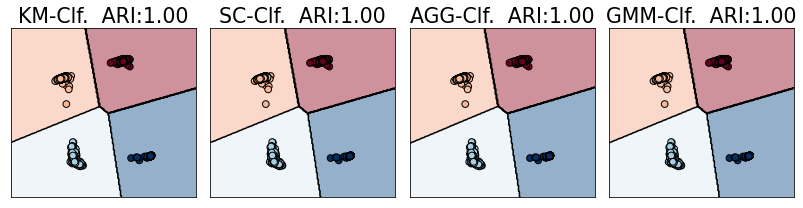

In [16]:
eval_embedding = encode_batchwise_from_data(data=data_eval, model=model, device=device)
plot_classifier_probabilities(classifier_ensemble.classifiers, torch.from_numpy(eval_embedding), gt_labels=labels_eval, device=device, plot_centers=False)